https://www.sciencedirect.com/science/article/pii/S0378437108009485

In [1]:
%load_ext autoreload
%autoreload 2

# Grafos temporales (Temporal graphs)

## Proximidad temporal (Temporal proximity)

### Setup

Importar las librerías de trabajo:

In [2]:
import networkx as nx
import datetime
import pandas as pd
import sys

sys.path.append("..")
from temporal_graph import TemporalGraph

Generamos la data (data ejemplo del paper de Kostakos).

La diferencia de tiempo, la expresamos en días:

In [3]:
tiempos = [(2018, 12, 31),
           (2019, 1, 1),
           (2019, 1, 3),
           (2019, 1, 5),
           (2019, 1, 9),
           (2019, 1, 14),
           (2019, 1, 20)]

In [4]:
data = pd.DataFrame({
    'sender': ['A', 'A', 'E', 'B', 'B', 'D', 'A'],
    'recipient': ['B', 'C, E', 'D', 'C', 'D', 'B', 'D'],
    'time': [ datetime.datetime(A, mes, dia) for (A, mes, dia) in tiempos]
})
data

,sender,recipient,time
0,A,B,2018-12-31
1,A,"C, E",2019-01-01
2,E,D,2019-01-03
3,B,C,2019-01-05
4,B,D,2019-01-09
5,D,B,2019-01-14
6,A,D,2019-01-20


Con esta data, creamos el grafo temporal: 

<div class="alert alert-info">
<h4>Creación del grafo temporal</h4>
<p>Necesitamos enviarle al constructor ``todos`` los tiempos que entran en juego en la vida del grafo.</p>
<p>Con esto, el grafo temporal crea las columnas donde se ubicarán las instancia de los nodos.</p>
</div>

In [5]:
grafo_temporal = TemporalGraph(data.time)  # nuevo grafo temporal con los tiempos indicados

Con el grafo temporal construido, creamos las instancias y los enlaces desde la data de ejemplo:

In [6]:
grafo_temporal.build_links_from_data(data=data)  #  ( verbose mode on )

Enlace:  A B 2018-12-31 00:00:00 A1
Enlace:  A C 2019-01-01 00:00:00 A2
Enlace:  A E 2019-01-01 00:00:00 A2
Enlace:  E D 2019-01-03 00:00:00 E3
Enlace:  B C 2019-01-05 00:00:00 B4
Enlace:  B D 2019-01-09 00:00:00 B5
Enlace:  D B 2019-01-14 00:00:00 D6
Enlace:  A D 2019-01-20 00:00:00 A7


Y dibujamos para verificar la correcta creación de los enlaces:

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


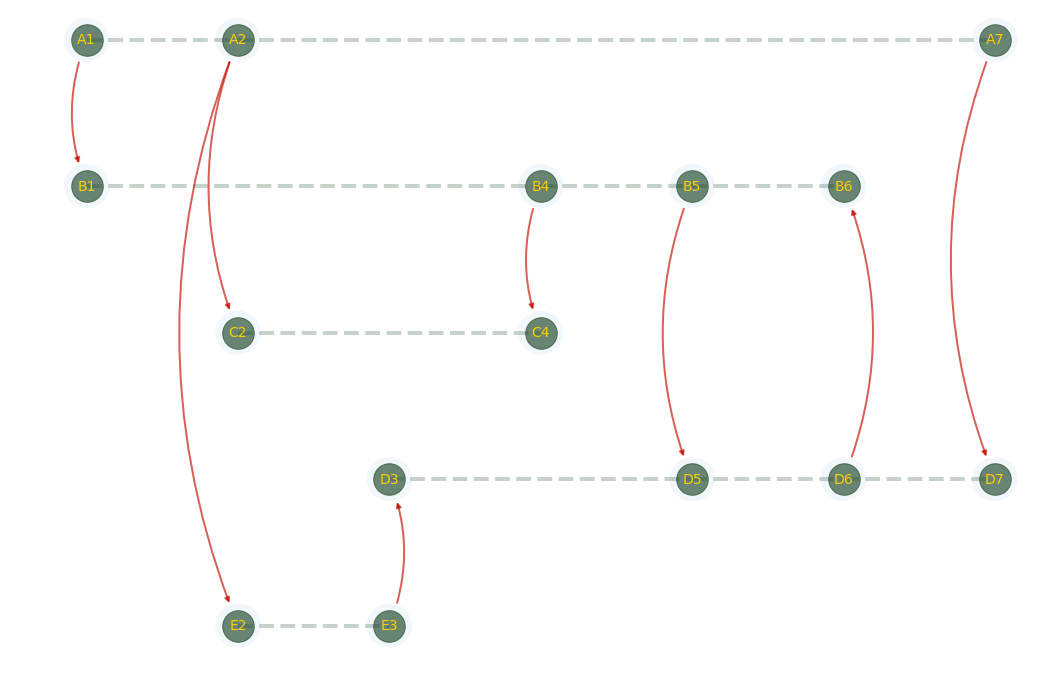

In [7]:
grafo_temporal.plot()

### Caminos (paths):

#### Instancias de los nodos:

Para trabajar con los caminos entre nodos, se construyeron los métodos: 
- *_get_first_instance_after_time*
- *_get_last_instance_before_time*


que reciben un nodo y un tiempo y retornan la primera instancia del nodo indicado desde/hasta el tiempo recibido, respectivamente, y que se utilizarán para calcular las distancias temporales entre dos nodos (un nodo puede tener muchas instancias).

In [8]:
grafo_temporal._get_first_instance_after_time('D', 5)

'D5'

In [9]:
grafo_temporal._get_last_instance_before_time('D', 4)

'D3'

In [10]:
try:
    grafo_temporal._get_first_instance_after_time('D', 9)
except Exception as e:
    print('Excepcion:\n', e)

Excepcion:
 No se puede encontrar una instancia del nodo "D" posterior al tiempo 9 recibido


Sin "tiempo desde", *_get_first_instance_after_time* devuelve la primera instancia encontrada:

In [11]:
grafo_temporal._get_first_instance_after_time('D')

'D3'

Sin "tiempo hasta", *_get_last_instance_before_time* devuelve la última instancia encontrada:

In [12]:
grafo_temporal._get_last_instance_before_time('C')

'C4'

Pruebas con nodos que no tienen instancias en los tiempos indicados:

In [13]:
grafo_temporal._get_last_instance_before_time('D', 4)

'D3'

In [14]:
grafo_temporal._get_last_instance_before_time('A', 5)

'A2'

In [15]:
grafo_temporal._get_first_instance_after_time('B', 2)

'B4'

-------------------------------------------------

# Proximidad temporal:

En nuestro caso, como nos manejamos con distancias de días, la distancia entre fechas python (datetime.datetime), nos retorna una cantidad en segundos.

Por lo cuál, generamos una funcion que nos pase una cantidad de tiempo en segundos a una cantidad de tiempo en días:

In [16]:
def seconds_to_days(seconds):
    if seconds is None:
        return None
    return (seconds / 3600) / 24

La distancia temporal entre un nodo X y un nodo Y está definida por:
    
- p(X,Y,t<sub>a</sub>,t<sub>b</sub>) 
    
donde t<sub>a</sub> es una precondición temporal y t<sub>b</sub> es una postcondicion temporal.

Ambas condiciones temporales (t<sub>a</sub> y t<sub>b</sub>) pueden tener un valor o ser null. Lo que nos deja 4 posibles casos.

### p(A,D,t<sub>i</sub>,t<sub>j</sub>): 

The shortest path between some instance of A, e.g. At2, and some instance of D, e.g. Dt7.

This example is equivalent to p(A,D,t<sub>2</sub>,t<sub>7</sub>) and intuitively means:

- “Given t<sub>2</sub>, find the shortest path from A to D such that D is reached at t<sub>7</sub>”.

In this case, the shortest path has weight w(At<sub>2</sub>,At<sub>7</sub>,Dt<sub>7</sub>) = 19, which translates back to AD.

In [17]:
shortest_path_from_A_to_D_at_2_to_7 = grafo_temporal.temporal_proximity('A', 'D', 2, 7)
shortest_path_from_A_to_D_at_2_to_7

['A2', 'A7', 'D7']

Peso del camino (segundos):

In [18]:
grafo_temporal.weight(shortest_path_from_A_to_D_at_2_to_7)

1641600.0

Peso del camino (días):

In [19]:
seconds_to_days(grafo_temporal.weight(shortest_path_from_A_to_D_at_2_to_7))

19.0

In [20]:
grafo_temporal.temporal_proximity('A', 'A', 2, 7)

['A2', 'A7']

In [21]:
grafo_temporal.temporal_proximity('A', 'D', 2, 5)

['A2', 'E2', 'E3', 'D3', 'D5']

### p(A,D,t<sub>i</sub>,null):

The shortest path between some instance of A, e.g. At<sub>1</sub>, and any instance of D ({Dt<sub>3</sub>, Dt<sub>5</sub>, Dt<sub>6</sub>, Dt<sub>7</sub>}).

This example is equivalent to p(A,D,t<sub>1</sub>, null), and intuitively means:
    
- “Given time t<sub>1</sub>, find the shortest path from A to D”.

In this case, the shortest path is AED with total weight w(At<sub>1</sub>,At<sub>2</sub>,Et<sub>2</sub>,Et<sub>3</sub>,Dt<sub>3</sub>) = 1+0+2+0=3. 

In [22]:
grafo_temporal.temporal_proximity('A', 'D', time_from=1, time_to=None)

# Igual a: 
# grafo_temporal.temporal_proximity('A', 'D', 1, None)
# O simplemente
# grafo_temporal.temporal_proximity('A', 'D', 1)

['A1', 'A2', 'E2', 'E3', 'D3']

Peso del camino:

In [23]:
seconds_to_days(grafo_temporal.weight(grafo_temporal.temporal_proximity('A',
                                                                        'D',
                                                                        time_from=1,
                                                                        time_to=None)))

3.0

In [24]:
grafo_temporal.temporal_proximity('A', 'D', time_from=2)

['A2', 'E2', 'E3', 'D3']

In [25]:
grafo_temporal.temporal_proximity('A', 'D', time_from=4)

['A7', 'D7']

In [26]:
grafo_temporal.temporal_proximity('B', 'E', time_from=2)

[]

In [27]:
grafo_temporal.temporal_proximity('B', 'D', time_from=2)

['B4', 'B5', 'D5']

##### Tests:

En los algoritmos internos, es conveniente saber si existe un camino desde un nodo a otro o saber todas las instancias de un nodo:

In [28]:
nx.algorithms.has_path(grafo_temporal.get_graph(), 'A1', 'D5')

True

In [29]:
grafo_temporal._get_node_instances('A')

['A1', 'A2', 'A7']

In [30]:
grafo_temporal._get_node_instances('A', from_time=2)

['A2', 'A7']

In [31]:
grafo_temporal._get_node_instances('A', from_time=4)

['A7']

In [32]:
grafo_temporal._get_node_instances('A', to_time=2)

['A1', 'A2']

In [33]:
grafo_temporal._get_node_instances('A', to_time=9)

['A1', 'A2', 'A7']

In [34]:
grafo_temporal._get_node_instances('A', to_time=1)

['A1']

In [35]:
print(help(grafo_temporal._get_node_instances))

Help on method _get_node_instances in module temporal_graph:

_get_node_instances(node_base, from_time=None, to_time=None) method of temporal_graph.TemporalGraph instance
    Devuelve las instancias en el tiempo para el nodo base recibido.
    
    Args:
        node_base (str): Nodo del cual se desean obtener las instancias.
    
        from_time (int): Indica que se desean obtener instancias que se encuentren en tiempos superiores (o igual) a este valor.
    
        to_time (int): Indica que se desean obtener instancias que se encuentren en tiempos inferiores (o igual) a este valor.
    
    Returns:
        list: Instancias del nodo recibido.
            Lista vacia si no hay instancias para el nodo.

None


### p(A,D,null,t<sub>i</sub>):

The shortest path between any instance of A ({At<sub>1</sub>, At<sub>2</sub>, At<sub>7</sub>}) and some instance of D, e.g. Dt<sub>5</sub>. 
    
This example is equivalent to p(A,D,null,t<sub>5</sub>) and intuitively means:

- "Find the shortest path from A to D such that D is reached at t<sub>5</sub>".

In this case, there are two shortest paths with weight w(At<sub>1</sub> At<sub>2</sub> Et<sub>2</sub> Et<sub>3</sub> Dt<sub>3</sub> Dt<sub>5</sub>) = w(At<sub>1</sub> Bt<sub>1</sub> Bt<sub>4</sub> Bt<sub>5</sub> Dt<sub>5</sub>) = 9, which translate back to AED and ABD respectively.

In [36]:
shortest_path = grafo_temporal.temporal_proximity('A', 'D', time_to=5)
shortest_path

['A1', 'B1', 'B4', 'B5', 'D5']

Peso del camino:

In [37]:
seconds_to_days(grafo_temporal.weight(shortest_path))

9.0

In [38]:
grafo_temporal.temporal_proximity('A', 'C', time_to=4)

['A1', 'B1', 'B4', 'C4']

In [39]:
grafo_temporal.temporal_proximity('A', 'C', time_to=5)

['A1', 'B1', 'B4', 'C4']

In [40]:
try:
    grafo_temporal.temporal_proximity('A', 'D', time_to=2)
except Exception as e:
    print(e)

El nodo destino D no tiene instancias anteriores al tiempo 2


### p(A,D,null,null): 

The shortest path between any instance of A ({At<sub>1</sub>, At<sub>2</sub>, At<sub>3</sub>, At<sub>7</sub>}) and any inst<sub>a</sub>nce of D ({Dt<sub>3</sub>, Dt<sub>5</sub>, Dt<sub>6</sub>, Dt<sub>7</sub>}). This intuitively means:
- "find the shortest possible path from A to D throughout the entire dataset".

In this case, the shortest path is w(At<sub>7</sub>,Dt<sub>7</sub>) = 0, which translates back to AD.

In [41]:
shortest_path = grafo_temporal.temporal_proximity('A', 'D')
shortest_path

['A7', 'D7']

In [42]:
seconds_to_days(grafo_temporal.weight(shortest_path))

0.0

In [43]:
grafo_temporal.temporal_proximity('B', 'D')

['B5', 'D5']

In [44]:
grafo_temporal.temporal_proximity('B', 'C')

['B4', 'C4']

In [45]:
grafo_temporal.temporal_proximity('E', 'A')

[]

In [46]:
grafo_temporal.temporal_proximity('E', 'B')

['E3', 'D3', 'D5', 'D6', 'B6']

In [47]:
grafo_temporal.temporal_proximity('E', 'D', time_from=2, time_to=6)

['E2', 'E3', 'D3', 'D5', 'D6']

### Peso del camino (Path weight): 

En las pruebas anteriores utilizamos una funcion de nuestro módulo de grafo temporal (_Class method_) para saber el peso de un camino.
Este método utiliza la información del enlace para obtener el peso y retornar la suma total de pesos del camino:

In [48]:
grafo_temporal.get_graph().get_edge_data('D5', 'D6')

{'weight': 432000.0}

In [49]:
grafo_temporal.weight(['D5', 'D6'])

432000.0

In [50]:
grafo_temporal.temporal_proximity('A', 'D', time_to=5)

['A1', 'B1', 'B4', 'B5', 'D5']

In [51]:
grafo_temporal.weight(['A1', 'A2', 'E2', 'E3', 'D3', 'D5'])

777600.0

In [52]:
grafo_temporal.weight(grafo_temporal.temporal_proximity('A', 'D', time_to=5))

777600.0

In [53]:
grafo_temporal.temporal_proximity('A', 'C', time_to=2)

['A1', 'A2', 'C2']

In [54]:
grafo_temporal.weight(['A1', 'A2', 'C2'])

86400.0

In [55]:
grafo_temporal.weight(['A1', 'A2'])

86400.0

## Proximidad temporal promedio:

__P(X,Y)__ mide _"en promedio, cuánto tiempo toma ir desde X hasta Y"_

In [56]:
avg_tmp_proximity = grafo_temporal.average_temporal_proximity('A', 'D')
print('''Proximidad temporal promedio desde A a D:
{} (segundos) --> {} (días)
'''.format(avg_tmp_proximity, seconds_to_days(avg_tmp_proximity)))

Proximidad temporal promedio desde A a D:
144000.0 (segundos) --> 1.6666666666666667 (días)



In [57]:
grafo_temporal.average_temporal_proximity('A', 'D', verbose=True)

Average temporal proximity from A to D

-- Iteration start --
Temporal proximity from A to D

	Searching from: A1
	From: A1
	Destination: D3?
		Have path, save: 
		['A1', 'A2', 'E2', 'E3', 'D3']
		next node instance destination...
In t:1
	distance from A to D
	path: ['A1', 'A2', 'E2', 'E3', 'D3']


Temporal proximity from A to D

	Searching from: A2
	From: A2
	Destination: D3?
		Have path, save: 
		['A2', 'E2', 'E3', 'D3']
		next node instance destination...
In t:2
	distance from A to D
	path: ['A2', 'E2', 'E3', 'D3']


Temporal proximity from A to D

	Searching from: A7
	From: A7
	Destination: D7?
		Have path, save: 
		['A7', 'D7']
		next node instance destination...
In t:7
	distance from A to D
	path: ['A7', 'D7']


-- Iteration finished --


144000.0

In [58]:
seconds_to_days(144000)

1.6666666666666667

In [59]:
# A a D desde t1
seconds = grafo_temporal.weight(['A1', 'A2', 'E2', 'E3', 'D3'])
(seconds/3600)/24

3.0

In [60]:
# A a D desde t2
seconds = grafo_temporal.weight(['A2', 'E2', 'E3', 'D3'])
((seconds)/3600)/24

2.0

In [61]:
(grafo_temporal.average_temporal_proximity('A', 'B', verbose=True) / 3600) / 24

Average temporal proximity from A to B

-- Iteration start --
Temporal proximity from A to B

	Searching from: A1
	From: A1
	Destination: B1?
		Have path, save: 
		['A1', 'B1']
		next node instance destination...
In t:1
	distance from A to B
	path: ['A1', 'B1']


Temporal proximity from A to B

	Searching from: A2
	From: A2
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['A2', 'E2', 'E3', 'D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:2
	distance from A to B
	path: ['A2', 'E2', 'E3', 'D3', 'D5', 'D6', 'B6']


Temporal proximity from A to B

	Searching from: A7
	From: A7
In t:7
	distance from A to B
	path: []


-- Iteration finished --


6.5

In [62]:
(grafo_temporal.average_temporal_proximity('A', 'C') / 3600) / 24

0.5

In [63]:
(grafo_temporal.average_temporal_proximity('A', 'D') / 3600) / 24

1.6666666666666667

In [64]:
(grafo_temporal.average_temporal_proximity('A', 'E') / 3600) / 24

0.5

In [65]:
(grafo_temporal.average_temporal_proximity('B', 'C') / 3600) / 24

2.5

In [66]:
(grafo_temporal.average_temporal_proximity('B', 'D') / 3600) / 24

4.333333333333333

Distancia temporal promedio nula:

In [67]:
grafo_temporal.average_temporal_proximity('B', 'A', verbose=True)

Average temporal proximity from B to A

-- Iteration start --
Temporal proximity from B to A

	Searching from: B1
	From: B1
	Destination: A1?
	Destination: A2?
	Destination: A7?
In t:1
	distance from B to A
	path: []


Temporal proximity from B to A

	Searching from: B4
	From: B4
	Destination: A7?
In t:4
	distance from B to A
	path: []


Temporal proximity from B to A

	Searching from: B5
	From: B5
	Destination: A7?
In t:5
	distance from B to A
	path: []


Temporal proximity from B to A

	Searching from: B6
	From: B6
	Destination: A7?
In t:6
	distance from B to A
	path: []


-- Iteration finished --


Distancia temporal promedio 0:

In [68]:
seconds_to_days((grafo_temporal.average_temporal_proximity('B', 'B', verbose=True)))

Average temporal proximity from B to B

-- Iteration start --
Temporal proximity from B to B

	Searching from: B1
	From: B1
	Destination: B1?
		Have path, save: 
		['B1']
		next node instance destination...
In t:1
	distance from B to B
	path: ['B1']


Temporal proximity from B to B

	Searching from: B4
	From: B4
	Destination: B4?
		Have path, save: 
		['B4']
		next node instance destination...
In t:4
	distance from B to B
	path: ['B4']


Temporal proximity from B to B

	Searching from: B5
	From: B5
	Destination: B5?
		Have path, save: 
		['B5']
		next node instance destination...
In t:5
	distance from B to B
	path: ['B5']


Temporal proximity from B to B

	Searching from: B6
	From: B6
	Destination: B6?
		Have path, save: 
		['B6']
		next node instance destination...
In t:6
	distance from B to B
	path: ['B6']


-- Iteration finished --


0.0

In [69]:
(grafo_temporal.average_temporal_proximity('D', 'B', verbose=True) / 3600) / 24

Average temporal proximity from D to B

-- Iteration start --
Temporal proximity from D to B

	Searching from: D3
	From: D3
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:3
	distance from D to B
	path: ['D3', 'D5', 'D6', 'B6']


Temporal proximity from D to B

	Searching from: D5
	From: D5
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['D5', 'D6', 'B6']
		next node instance destination...
In t:5
	distance from D to B
	path: ['D5', 'D6', 'B6']


Temporal proximity from D to B

	Searching from: D6
	From: D6
	Destination: B6?
		Have path, save: 
		['D6', 'B6']
		next node instance destination...
In t:6
	distance from D to B
	path: ['D6', 'B6']


Temporal proximity from D to B

	Searching from: D7
	From: D7
In t:7
	distance from D to B
	path: []


-- Iteration finished --


5.333333333333333

In [70]:
(grafo_temporal.average_temporal_proximity('E', 'B', verbose=True) / 3600) / 24

Average temporal proximity from E to B

-- Iteration start --
Temporal proximity from E to B

	Searching from: E2
	From: E2
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['E2', 'E3', 'D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:2
	distance from E to B
	path: ['E2', 'E3', 'D3', 'D5', 'D6', 'B6']


Temporal proximity from E to B

	Searching from: E3
	From: E3
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['E3', 'D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:3
	distance from E to B
	path: ['E3', 'D3', 'D5', 'D6', 'B6']


-- Iteration finished --


12.0

### Por último, construir la tabla de proximidades temporales promedio.

In [71]:
seconds_to_days(
    grafo_temporal.average_temporal_proximity('B', 'D'))

4.333333333333333

In [72]:
seconds_to_days(
    grafo_temporal.average_temporal_proximity('D', 'B'))

5.333333333333333

Internamente, utilizamos __average_temporal_proximity__ para calcular las distancias temporales hacia un nodo en particular con el método __average_temporal_proximity_to_node__.
Con este método, vamos construyendo las columnas de la tabla de distancias temporales promedio, P<sub>in</sub> y P<sub>out</sub>.

Nodos:

In [73]:
nodos = list(pd.Series(data.sender.unique()).append(pd.Series(data.recipient[ data.recipient.str.len() == 1].unique())))
nodos = sorted(list(set(nodos)))
nodos

['A', 'B', 'C', 'D', 'E']

Función para dar formato las distancias temporales promedios:

In [74]:
def formatear(valor):
    '''Formatea un flotante, si es None, retorna - (un guión)'''
    if valor is None:
        return '-'
    return '{:.2f}'.format(valor)

Creamos una diccionario python que será la entrada para el dataframe de P, P<sub>in</sub> y P<sub>out</sub>:


Cada clave del diccionario corresponde a una columna de la tabla:

In [75]:
table = {}
P_outs = []
for nodo in nodos:
    # Para cada nodo:
    # Primero calcular las proximidades temporales promedios contra los demas nodos:
    table[nodo] = [formatear(seconds_to_days(proximity))
                   for proximity
                   in grafo_temporal.average_temporal_proximity_to_node(nodo).values()]
    
    # Luego agregar a la lista el promedio de alcance hacia el nodo
    # por parte de los demas nodos (Pin):
    table[nodo].append(
        formatear(
            seconds_to_days(
                grafo_temporal.average_temporal_reachability(nodo))))
    
    P_outs.append(
        formatear(
            seconds_to_days(
                grafo_temporal.average_temporal_reach(nodo))))

P_outs.append('-')
table['Pout'] = P_outs
table

{'A': ['0.00', '-', '-', '-', '-', '-'],
 'B': ['6.50', '0.00', '-', '5.33', '12.00', '7.94'],
 'C': ['0.50', '2.50', '0.00', '-', '-', '1.50'],
 'D': ['1.67', '4.33', '-', '0.00', '1.00', '2.33'],
 'E': ['0.50', '-', '-', '-', '0.00', '0.50'],
 'Pout': ['2.29', '3.42', '-', '5.33', '6.50', '-']}

In [76]:
index = nodos.copy()
index.append('Pin')
index

['A', 'B', 'C', 'D', 'E', 'Pin']

In [77]:
average_temporal_proximities = pd.DataFrame(table, index=index)
average_temporal_proximities

,A,B,C,D,E,Pout
A,0.00,6.50,0.50,1.67,0.50,2.29
B,-,0.00,2.50,4.33,-,3.42
C,-,-,0.00,-,-,-
D,-,5.33,-,0.00,-,5.33
E,-,12.00,-,1.00,0.00,6.50
Pin,-,7.94,1.50,2.33,0.50,-


### Métodos utilizados:

#### Proximidades temporales promedios contra los demás nodos:

#### Desde un nodo:

Solicitar la primera fila horizontal de la tabla anterior:

In [78]:
avg_tmp_proxs_from_a = grafo_temporal.average_temporal_proximity_from_node('A')
avg_tmp_proxs_from_a

{'A': 0.0, 'B': 561600.0, 'C': 43200.0, 'D': 144000.0, 'E': 43200.0}

pasar a dias:

In [79]:
[seconds_to_days(avg_tmp_proxs_from_a.get(e)) for e in avg_tmp_proxs_from_a]

[0.0, 6.5, 0.5, 1.6666666666666667, 0.5]

Alcance del nodo hacia el resto de nodos del grafo (promedio de los valores no nulos del vector de arriba):

In [80]:
grafo_temporal.average_temporal_reach('A')

198000.0

...expresado en días (**corresponde a Pout para el nodo A**):

In [81]:
seconds_to_days(grafo_temporal.average_temporal_reach('A'))

2.2916666666666665

mismo test para el nodo E:

In [82]:
print(
    grafo_temporal.average_temporal_proximity_from_node('E'),
    '--> P out:',
    seconds_to_days(grafo_temporal.average_temporal_reach('E')))

{'A': None, 'B': 1036800.0, 'C': None, 'D': 86400.0, 'E': 0.0} --> P out: 6.5


#### Alcance hasta un nodo (columnas de la tabla):

In [83]:
grafo_temporal.average_temporal_proximity_to_node('A')

{'A': 0.0, 'B': None, 'C': None, 'D': None, 'E': None}

In [84]:
grafo_temporal.average_temporal_proximity_to_node('D')

{'A': 144000.0, 'B': 374400.0, 'C': None, 'D': 0.0, 'E': 86400.0}

Columna para el nodo 'D:' 

In [85]:
aux = grafo_temporal.average_temporal_proximity_to_node('D')
print(
    [seconds_to_days(proximity) for proximity in aux.values()])

[1.6666666666666667, 4.333333333333333, None, 0.0, 1.0]


"Alcanzabilidad":

In [86]:
alcanzabilidad = grafo_temporal.average_temporal_reachability('D')
print(alcanzabilidad, '-->', seconds_to_days(alcanzabilidad))

201600.0 --> 2.3333333333333335


In [87]:
aux = grafo_temporal.average_temporal_proximity_to_node('D')
print(
    [seconds_to_days(proximity) for proximity in aux.values()],
    '--> P in:',
    seconds_to_days(grafo_temporal.average_temporal_reachability('D'))
)


[1.6666666666666667, 4.333333333333333, None, 0.0, 1.0] --> P in: 2.3333333333333335


In [88]:
print(help(grafo_temporal.average_temporal_reach))

Help on method average_temporal_reach in module temporal_graph:

average_temporal_reach(node) method of temporal_graph.TemporalGraph instance
    On average, how quickly does X reach the rest of the network.
    
    Lease: ```P out```
    
    Args:
        node (str): Nodo. Por ejemplo: 'A'.
    
    Returns:
        float, o None si desde el nodo no se alcanza ningun otro nodo.

None


In [89]:
print(help(grafo_temporal.average_temporal_reachability))

Help on method average_temporal_reachability in module temporal_graph:

average_temporal_reachability(node) method of temporal_graph.TemporalGraph instance
    On average, how quickly is X reached by the rest of the network.
    
    Lease: ```P in```
    
    Args:
        node (str): Nodo. Por ejemplo: 'A'.
    
    Returns:
        float, o None si el nodo no es alcanzado por ningun otro nodo.

None
